# Region convolutional neural network (R-CNN) object detetion with Keras, TensorFlow and Deep Learning
(Under develepment)

***This juppyter notebook is not organized and are just unorganized notes taked during my study.***

Four steps [reference](https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55): 
1. Pass the image through selective search and generate region proposal.
2. Calculate IOU (intersection over union) on proposed region with groud truth data and add label to the proposed regions
3. Do transfer learning using the proposed regions with the labels.
4. Pass the test image to selective search and then passe the first 2000 proposed regions from the trained model and predict the class of those regions.

Six steps [reference](https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/):
1. Build object detection dataset with Selective Search
2. Fine-tune classification model on dataset
3. During inference, run Selective Search on input image
4. Make predictions on each proposal using fine-tuned model
5. Apply NMS (non-maxima suprssion)
6. Return final object detection results

## Data set

The dataset used is the [German Traffic Signs Dataset](https://medium.com/datadriveninvestor/traffic-sign-recognition-using-convolutional-neural-networks-cnn-f7dc5d9d53ba) containing images of shape (32x32x3)



*   The training set has 34799 images
*   The validation set has 4410 images
*   The test set has 12630 images
*   The dataset has **43 unique classes**


**Structure:**
*  One directory per class
*  Each directory container CSV file wit annotations name: GT\<class id \>.csv and the training images
*  training images grouped by tracks (each track has 30 images of one single traffic sign)


**Annotation structure:**
+  CSV with 8 columns
    +  **Filename**
    + **Width**
    + **Height**
    + **x of top left corner**
    + **y of top left corner**
    + **x bottom right corner**
    + **y of bottom right corner**
    + **class id**


We are going to use the same dataset with the [training](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip) and [test](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip) data in a different format.

You can get the train data [here](https://drive.google.com/file/d/1AZeKw90Cb6GgamTBO3mvDdz6PjBwqCCt/view) with the label values [here](https://www.murtazahassan.com/wp-content/uploads/2020/08/labels.zip)


___
### **Region of Interest (ROI)**
The region of interest (ROI) are defined in the file gt.txt

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os

### Intersection over Union
[Reference](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

Intersection over Union (IOU) is an **evaluation metric** used to measure the accuracy of an object detetor on a particular dataset. In order to apply IOU to evaluate an (arbitrary) object detector we need:
1. The groundh-trhith bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
2. The predicted bounding boxes from our model

The IOU can be determined via:
$$ IOU = \frac{Area \; of \; Overlap}{Area \; of \; Union}$$

An IOU score > 0.5 is normally considered a "good" prediction.

In [4]:
# Function to calculate IOU (Intersection Over Union)

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']    
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])    
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0    
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)    
    
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])    
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

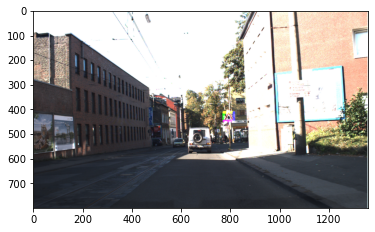

In [10]:
folder = !ls "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"*.ppm

import cv2
import matplotlib.pyplot as plt
import numpy as np 

image = cv2.imread(folder[0]) # load the image (read in BGR)
line_image = np.zeros_like(image)
cv2.line(line_image, (774,411), (774, 446), (0,255,0), thickness=10)
cv2.line(line_image, (774,411), (815, 411), (255,255,0), thickness=10)
cv2.line(line_image, (774,446), (815, 446), (255,0,255), thickness=10)
cv2.line(line_image, (815,411), (815, 446), (0,0,255), thickness=10)
#plt.imshow(image[...,(2,1,0)])
combo_image = cv2.addWeighted(image[...,(2,1,0)], 1, line_image, 1, 1)
plt.imshow(combo_image)
#plt.imshow(line_image)
#plt.show()
#img = cv2.imread('messi5.jpg',0)

#ImgNo#.ppm;#leftCol#;##topRow#;#rightCol#;#bottomRow#;#ClassID#
#774;411;815;446

In [6]:
data_folder = "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"
figures_list = !ls "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"*.ppm


In [9]:
# Region of Interest
# (bounding boxes)

gt = open(data_folder +"gt.txt", "r")
content = gt.read()#line()
#print(content)
gt.close()
content = content.split()

for k in range(len(content)):
    content[k] = content[k].split(';')
    content[k][0] = content[k][0].split('.')[0]
    for k2 in range(len(content[k])):
        content[k][k2] = int(content[k][k2])


**Image pyramids**: Localize objects at different scales/sizes.
**Sliding windows**: Detect exactly where in the iage a given object is.
**Non-maxima supression**: Collapse weak, overlaping bounding boxes.

Flow of the algorithm:
1. Input an image
2. Construct an image pyramid
3. For each scale of the image pyramid, run a sliding window:
    * 3a - For each stop of the sliding window, extract the ROI
    * 3b - Take the ROI and pass it through our CNN originally trained for image classification
    * 3c - Examine the probability of the top class label of the CNN, and if meets a minimum confidence, record (1) the class label and (2) the location of the sliding window
4. pply class-wise non-maxima supression to the bounding boxes
5. Return results to calling function



____
### Implementing our image pyramid and sliding window utility functions
[Reference](https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/)

image_pyramid - Assists in generating copies of our image at different scales so that we can find objects of different sizes ([Reference](https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/))

sliding_window - Helps us find where in the image an object is by sliding our classification window from left-to-righ (column-wise) and top-to-bottom (row-wise) ([Reference](https://www.pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/))

In [169]:
pip install --upgrade imutils
# https://github.com/jrosebr1/imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25853 sha256=35837810b40369c4f9352580217de17110aa640354622886f43439bb0200bccf
  Stored in directory: /home/erst/.cache/pip/wheels/c8/d6/0f/b0c3892b70c59f0d202f8619a449f7d14cb839a0af2f943869
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [8]:

import imutils

def sliding_window(image, step, ws):
    '''
    image - input image
    step - step size of the sliding (it is common to use steps of 4 to 8 pixels)
    ws - window size. Defines the width and height (in pixels) of the window we are going to extract from the image
    '''
    # slide a window across the image
    for y in range(0,image.shape[0] - ws[1], step): # loop over rows
        for x in range(0, image.shape[1] - ws[0], step): # loop over columns
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])


def pyramid(image, scale=1.5, minSize=(30, 30)):
    '''
    image - input image
    scale - controls by how much the image is resized at each layer
    minSize - is the minimum required width and height of the layer. If an image in the pyramid falls below this minSize, the construction of the pyramid is stopped.
    '''
    # yield the original image
    yield image
    
    #keep looping over the pyramid
    while True:
        # keep looping over new dimensions of the image and resize it
        w = int(image.shape[1]/scale)
        image = imutils.resize(image, width=w)
        
        # if the resized image does not meet the supplied minimum
        # size, then stop constructin the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
            
        # yield the next image in the pyramid
        yield image
        
            
            
import cv2
import time

figures_list = !ls "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"*.ppm
image = cv2.imread(figures_list[0])
(winW, winH) = (128,128)

# loop over the image pyramid
for resized in pyramid(image, scale=1.5):
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, step=32, ws =(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        clone = resized.copy()
        cv2.rectangle(clone, (x,y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2.imshow("Window",clone)
        cv2.waitKey(1)
        time.sleep(0.025)

____
### Using Keras and TensorFlow to turn a pre-trained image classifier into an object detector



In [36]:
!python3 funcs/detect_with_classifier.py --image funcs/index.jpeg --size "(200,200)"


2020-12-30 13:09:04.341838: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-12-30 13:09:04.341929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[INFO] loading network...
2020-12-30 13:09:05.372342: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-12-30 13:09:05.372412: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-12-30 13:09:05.372436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2020-12-30 13:09:05.372580: I tensorflow/cor

In [39]:
!python3 funcs/detect_with_classifier.py --image funcs/00001.ppm --size "(200,200)"

2020-12-30 16:19:17.526572: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-12-30 16:19:17.526613: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[INFO] loading network...
2020-12-30 16:19:18.575971: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-12-30 16:19:18.576011: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-12-30 16:19:18.576042: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2020-12-30 16:19:18.576219: I tensorflow/cor

____
## OpenCV Selective Search for Object Detection
[Reference](https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/)

### What is selective search and how can Selective Search be used for object detection?
Selective search works by over-segmenting an image using a superpixel algorithm.

Selective search seeks to merge together the superpixels to find regions of an image that could contain an object.

Selective search merge superpixels in a hierarchical fashion based on five key similarity measures:
* **Color similarity**: computing a 25-bin histogram for each channel of an image, concatenating them together and obtaining a final descriptor that is $25\times3=75d$.
* **Texture similarity**: Selective search extracts Gaussian derivatives at 8 orientation per channel. These orientations are used to compute a 10-bin histogram per channel, generating a final texture descriptor that ins $8\times10\times3=240d$. To compute texture similarity between any two regions, histogram intersection is once again used.
* **Size similarity**: Smaller regions are grouped earlier rather than later.
* **Shape similarity/compatibility**: The idea behind shape similarity in Selective Search is that they should be compatible with each other. Two regions are considered “compatible” if they “fit” into each other (thereby filling gaps in our regional proposal generation). Furthermore, shapes that do not touch should not be merged.
* **A final meta-similarity measure**: A final meta-similarity acts as a linear combination of the color similarity, texture similarity, size similarity, and shape similarity/compatibility.

**Selective Search will not tell you what is in the ROI, but it tells you that the ROI is “interesting enough” to passed on to a downstream classifier (ex., SVM, CNN, etc.) for final classification.**

In most cases, the “fast” Selective Search is sufficient, but you may choose to use the “quality” mode:
* When performing inference and wanting to ensure you generate more quality regions to your downstream classifier (of course, this means that real-time detection is not a concern)
* When using Selective Search to generate training data, thereby ensuring you generate more positive and negative regions for your classifier to learn from

In [44]:
#!python3 funcs/selective_search.py --image funcs/index.jpeg
!python3 funcs/selective_search.py --image funcs/00001.ppm --method quality

[INFO] using *quality* selective search
[INFO] selective search took 73.0959 seconds
[INFO] 45442 total region proposals
QObject::moveToThread: Current thread (0x563d230f5980) is not the object's thread (0x563d1c017080).
Cannot move to target thread (0x563d230f5980)

QObject::moveToThread: Current thread (0x563d230f5980) is not the object's thread (0x563d1c017080).
Cannot move to target thread (0x563d230f5980)

QObject::moveToThread: Current thread (0x563d230f5980) is not the object's thread (0x563d1c017080).
Cannot move to target thread (0x563d230f5980)

QObject::moveToThread: Current thread (0x563d230f5980) is not the object's thread (0x563d1c017080).
Cannot move to target thread (0x563d230f5980)

QObject::moveToThread: Current thread (0x563d230f5980) is not the object's thread (0x563d1c017080).
Cannot move to target thread (0x563d230f5980)

QObject::moveToThread: Current thread (0x563d230f5980) is not the object's thread (0x563d1c017080).
Cannot move to target thread (0x563d230f5980

## Region proposal object detection with OpenCV, Keras, and TensorFlow
[Reference](https://www.pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/)

*Question answered in this tutorial*: How do we take the region proposals (i.e., regions of an image that could contain an object of interest) and then actually classify them to obtain our final object detection?

### What are region proposals, and how can they be used for object detection?
Region proposal algorithms seek to replace the traditional image pyramid and sliding window approach. These algorithms:
* Accept an input image
* Over-segment it by applying a superpixel clustering algorithm
* Merge segments of the superpixels based on five components (color similarity, texture similarity, size similarity, shape similarity/compatibility, and a final meta-similarity that linearly combines the aforementioned scores)

Region proposal algorithms have no idea if a given region does in fact contain an object. Region proposal methods simply tell us "Hey, this looks like an interesting region of the input image. Let’s apply our more computationally expensive classifier to determine what’s actually in this region."

Region proposal algorithms tend to be far more efficient than the traditional object detection techniques of image pyramids and sliding windows because:
* Fewer individual ROIs are examined
* It is faster than exhaustively examining every scale/location of the input image
* The amount of accuracy lost is minimal, if any


In [50]:
#!python funcs/region_proposal_detection.py --image funcs/index.jpeg
!python funcs/region_proposal_detection.py --image funcs/00001.ppm #--filter traffic signal

2020-12-30 19:50:06.984324: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-12-30 19:50:06.984365: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[INFO] loading ResNet...
2020-12-30 19:50:08.056120: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-12-30 19:50:08.056167: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-12-30 19:50:08.056190: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2020-12-30 19:50:08.056569: I tensorflow/core

## R-CNN object detection with Keras, TensorFlow and Depp Learning

### Steps to implementing and R-CNN object detector with Keras and TensorFlow
* **Step 1**: Build object detection dataset with Selective Search.
* **Step 2**: Fine-tune classification model on dataset.
* **Step 3**: Create an object detection inference script that utilizes Selective Search to propose regions that could contain an object that we would like to detect.
* **Step 4**: Use our fine-tuned network to classify each region proposed via Selective Search
* **Step 5**: Apply non-maxima suppression to suppress weak, overlapping bounding boxes
* **Step 6**: Return final object detection results.


### Implementing our object detection dataset builder script
(build_dataset.py)

* **Step #1**: Input directory of images.
* **Step #2**: Loop over all images in dataset.
* **Step #2a**: Load input image.
* **Step #2b**: Load and parse bounding boxes for any traffic signal in the input image.
* **Step #3**: Run Selective Search on input image.
* **Step #4**: Determine which bounding boxes overlap with ground-truth.
Use IoU to determine which region proposals from Selective Search sufficiently overlap with the ground-truth bounding boxes and which ones do not.
* **Step #5**: Sample regions that *do* versus *do not* overlap with ground-truth.



We will refer to:
- `positiveROIs` - as the number of region proposals for the current image that (1) sufficiently overlap with ground-truth annotations and (2) are save to disk in the path contained in config.POSITIVE_PATH

- `negativeROIs` - as the number of region proposal for the current image that (1) fail to meet our IoU threshold of 70% and (2) are saved to disk to the config.NEGATIVE_PATH.


___
## Fine-tuning a network for object detection with Keras and TensorFlow

### 0 Review of important ground concepts:
#### 0.1 Transfer learning with Keras and Deep Learning 
[Reference 1](https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/)

**Transfer learning** is the process of:
1. Taking a network pre-trained on a dataset
2. And utilizing it to recognize image/object categories it was not trained on

Essentially, we can utilize the robust, discriminative filters learned by state-of-the-art networks on challenging datasets (such as ImageNet or COCO), and then apply these networks to recognize objects the model was never trained on.

In general, there are two types of transfer learning in the context of deep learning:
* Transfer learning via feature extraction
* Transfer learning via fine-tuning

When performing ***feature extraction***, we treat the pre-trained network as an arbitrary feature extractor, allowing the input image to propagate forward, stopping at pre-specified layer, and taking the outputs of that layer as our features.

***Fine-tuning***, on the other hand, requires that we update the model architecture itself by removing the previous fully-connected (FC) layer heads, providing new, freshly initialized ones, and then training the new FC (Fully-Connected) layers to predict our input classes.

#### 0.2 Keras: Feature extraction on large datasets with Deep Learning
[Reference 2](https://www.pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/)

#### 0.3 Fine-tuning with Keras and Deep Learning
[Reference 3](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)